In [170]:
import requests, json
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon
import matplotlib.pyplot as plt
from datetime import datetime
NWSAPIURLSTART = 'https://api.weather.gov'

def get_location_url_from_coords(lat,lon):
    return NWSAPIURLSTART + '/points/' +str(lat) + ',' + str(lon)

def get_gridX_gridY_office_from_location_url(location_url):
    r = requests.get(location_url)
    if (r.status_code == 200):
        j = json.loads(r.text)
        d = {}
        d['gridX'] = j['properties']['gridX']
        d['gridY'] = j['properties']['gridY']
        d['office'] = j['properties']['cwa']
        return d
    else:
        print(r)

        
def get_grid_endpoint_from_dict(d):
    return NWSAPIURLSTART + '/gridpoints/' + str(d['office']) + '/' + str(d['gridX']) + ',' + str(d['gridY'])



In [171]:
r = requests.get('https://gist.githubusercontent.com/Miserlou/c5cd8364bf9b2420bb29/raw/2bf258763cdddd704f8ffd3ea9a3e81d25e2c6f6/cities.json')
r

<Response [200]>

In [172]:
j = json.loads(r.text)

In [173]:
print(j[0].keys())
print(j[0]['latitude'])
print(j[0]['longitude'])
print(j[0]['city'])
print(j[0]['state'])

dict_keys(['city', 'growth_from_2000_to_2013', 'latitude', 'longitude', 'population', 'rank', 'state'])
40.7127837
-74.0059413
New York
New York


In [174]:
url = get_location_url_from_coords(j[0]['latitude'], j[0]['longitude'])
print(url)

https://api.weather.gov/points/40.7127837,-74.0059413


In [175]:
lr = requests.get(url)

In [176]:
lj = json.loads(lr.text)
print(lj['properties']['gridX'])
print(lj['properties']['gridY'])
print(lj['properties']['cwa'])

32
34
OKX


In [177]:
gridpointsurl = get_grid_endpoint_from_dict(get_gridX_gridY_office_from_location_url(url))
print(gridpointsurl)

https://api.weather.gov/gridpoints/OKX/32,34


In [178]:
gridr = requests.get(gridpointsurl)
gridr

<Response [200]>

In [179]:
gridjson = json.loads(gridr.text)
gridjson.keys()

dict_keys(['@context', 'id', 'type', 'geometry', 'properties'])

In [180]:
gridjson['geometry']['coordinates'][0]
time_nws = gridjson['properties']['validTimes']
t1 = datetime.strptime(time_nws.split('+')[0], '%Y-%m-%dT%H:%M:%S').timestamp()
print(t1)
two_days_old = t1-(2*24*60*60)
print(two_days_old)

1657648800.0
1657476000.0


In [181]:

polygon_points = []
for coord in gridjson['geometry']['coordinates'][0]:
    polygon_points.append(Point(coord[1],coord[0]))
box = Polygon(polygon_points)
for point in polygon_points:
    print(point.x)
    print(point.y)
box.contains(Point(40.7127837,-74.0059413))
print(datetime.now().timestamp())

40.7270524
-74.0250952
40.7053617
-74.0295579
40.7019775
-74.0009483
40.723667899999995
-73.9964798
40.7270524
-74.0250952
1657658491.139978


In [ ]:
missed_gridpoints = 0
successful_gridpoints = 0
miles_off = []
off_grid_points = []


bad_times = []
now_time = datetime.now().timestamp()
two_days_old = (now_time - (2*24*60*60))
gridpoints_too_old = 0
gridpoints_good_time = 0


for city in j[:250]:
    print(city['city'])
    city_lat = city['latitude']
    city_lon = city['longitude']
    url = get_location_url_from_coords(city_lat, city_lon)
    print(url)
    gridpointsurl = get_grid_endpoint_from_dict(get_gridX_gridY_office_from_location_url(url))
    print(gridpointsurl)
    gridpoint_request = requests.get(gridpointsurl)
    if gridpoint_request.status_code ==200:
        grid_json = json.loads(gridpoint_request.text)
        polygon_points = []
        for coord in grid_json['geometry']['coordinates'][0]:
            polygon_points.append(Point(coord[1],coord[0]))
        box = Polygon(polygon_points)
        city_point = Point(city_lat,city_lon)
        grid_correct = box.contains(city_point)
        if grid_correct:
            successful_gridpoints += 1
        if not grid_correct:
            off_grid_points.append(city_point)
            missed_gridpoints += 1
            dist_miles = 68*box.exterior.distance(city_point)
            print(str(city_lat) + ',' + str(city_lon) + ' is not in ' + str(grid_json['geometry']['coordinates'][0]))
            print("distance off: rough miles (vector dist * 68 mi): " + str(dist_miles))
            miles_off.append(dist_miles)
        forecast_time = grid_json['properties']['validTimes']
        forecast_timestamp = datetime.strptime(time_nws.split('+')[0], '%Y-%m-%dT%H:%M:%S').timestamp()
        if forecast_timestamp < two_days_old:
            print("more than two days old")
            print(forecast_time)
            bad_times.append(forecast_time)
            gridpoints_too_old += 1
        if forecast_timestamp > two_days_old:
            gridpoints_good_time += 1
            
            

    
        
    

New York
https://api.weather.gov/points/40.7127837,-74.0059413
https://api.weather.gov/gridpoints/OKX/32,34
Los Angeles
https://api.weather.gov/points/34.0522342,-118.2436849
https://api.weather.gov/gridpoints/LOX/154,44
Chicago
https://api.weather.gov/points/41.8781136,-87.6297982
https://api.weather.gov/gridpoints/LOT/75,72
Houston
https://api.weather.gov/points/29.7604267,-95.3698028
https://api.weather.gov/gridpoints/HGX/63,94


In [ ]:
print('lat lon not in grid:' + str(missed_gridpoints))
print('lat lon successful:' + str(successful_gridpoints))
print("error rate %: " +str(missed_gridpoints/ (successful_gridpoints+missed_gridpoints)))
import statistics
print('average distance to grid' + str(statistics.mean(miles_off)))
print(max(miles_off))
print(min(miles_off))
print('# of forecasts > 2 days old:' + str(gridpoints_too_old))

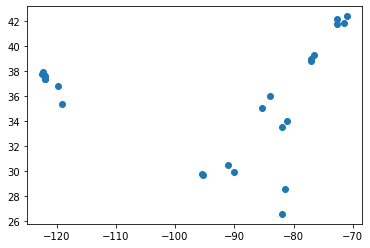

In [169]:
xs =[point.x for point in off_grid_points]
ys =[point.y for point in off_grid_points]
plt.scatter(ys,xs)

False